# **Setup and resources**

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from  torch.utils.data import Dataset

from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2

Import google drive to save and load models

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


The first part of the assignment is to build a CNN and train it on a subset of the ImageNet dataset. We will first create a dataframe with all the references to the images and their labels.

In [0]:
#To download the images into your work environment, clone into a git respository containing the images.

! git clone https://github.com/MohammedAlghamdi/imagenet10.git

Cloning into 'imagenet10'...
remote: Enumerating objects: 10019, done.
remote: Total 10019 (delta 0), reused 0 (delta 0), pack-reused 10019
Receiving objects: 100% (10019/10019), 966.71 MiB | 38.97 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (10002/10002), done.


In [0]:
# Check that the repository is there:

! dir

root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

imagenet10  sample_data


A helper function for reading in images and assigning labels.

In [0]:
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

Now we create a dataframe using all the data.

In [0]:
# Benign images we will assign class 0, and malignant as 1
paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

View some sample data.

In [0]:
print("Found", len(data_df), "images.")
data_df.head()

Found 9000 images.


,path,class
0,imagenet10/train_set/football/n04254680_5825.JPEG,7
1,imagenet10/train_set/desk/n03179701_5614.JPEG,4
2,imagenet10/train_set/baboon/n02486410_2676.JPEG,0
3,imagenet10/train_set/canoe/n02951358_5216.JPEG,2
4,imagenet10/train_set/football/n04254680_2254.JPEG,7


# **Building the network**

Now we will create the Dataset class.

In [0]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

Compute what we should normalise the dataset to.

In [0]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs

norm_mean, norm_std = compute_img_mean_std(paths)

100%|██████████| 9000/9000 [00:44<00:00, 203.69it/s]


(224, 224, 3, 9000)
normMean = [0.5228359, 0.4798834, 0.40605333]
normStd = [0.29770732, 0.28883994, 0.31178218]


Now let's create the transforms to normalise and turn our data into tensors.

In [0]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

Let's split the data into train and test sets and instantiate our new ISIC_Dataset objects.

In [0]:
train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)

DataLoaders for the datasets.

In [0]:
train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

valid_loader = torch.utils.data.DataLoader(
    ins_dataset_valid,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=8, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

You can optionally seed the Random Number Generator across all devices for testing purposes.

In [0]:
torch.manual_seed(1)

We can now create device where we refer to GPU or CPU.

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Define Accuracy function

In [0]:
def compute_validation_stats(loader):
    global model

    # Accuracy parameters
    correct = 0
    total = 0
    accuracy = 0
    labels_total = torch.tensor([], dtype=torch.long)
    predicted_total = torch.tensor([], dtype=torch.long)
    # Loss parameters
    validation_loss = 0    

    model.eval()
    with torch.no_grad():
    
        # Iterate over the validation set
        for data in loader:
            images, labels = data
        
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = model(images)
        
            # Accuracy
            # torch.max is an argmax operation
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            labels_total = torch.cat((labels_total, labels.cpu()))
            predicted_total = torch.cat((predicted_total, predicted.cpu()))

            # Loss
            logps = model.forward(images)
            batch_loss = criterion(logps, labels)
            validation_loss += batch_loss.item() 

    model.train()
    return labels_total, predicted_total, (100 * correct / total), (validation_loss / len(loader))

Define Train function

In [0]:
import matplotlib.pyplot as plt
import copy 

def train_model_epochs(num_epochs):
    """ Copy of function train_model_epochs but explicitly copying data to device 
        during training. 
    """

    global model
    best_model_loss = 9
    best_model = []

    train_losses, validation_losses, validation_accuracies = [], [], []

    for epoch in range(num_epochs):

        # Train data
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            images, labels = data

            # Explicitly specifies that data is to be copied onto the device!
            images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
            labels = labels.to(device)  # <----------- variables still exist on CPU

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
              print('Epoch / Batch [%d / %d]' %
                      (epoch + 1, i + 1))

        # Validation data
        _, _, validation_accuracy, validation_loss = compute_validation_stats(valid_loader)
        running_loss = running_loss / len(train_loader)
        train_losses.append(running_loss)
        validation_losses.append(validation_loss) 
        validation_accuracies.append(validation_accuracy)  

        if best_model_loss > validation_loss:
          best_model_loss = validation_loss
          best_model = copy.deepcopy(model)

        print(f"-------------------------------- \n"
              f"  Epoch {epoch+1}/{num_epochs} \n"
              f"  Train loss: {running_loss:.3f} \n"
              f"  Validation loss: {validation_loss:.3f} \n"
              f"  Validation accuracy: {validation_accuracy:.3f}% \n"
              f"--------------------------------")
        model.train()
    
    plt.plot(train_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')
    plt.legend(frameon=False)
    #path = f"/content/gdrive/My Drive/Escola/Master/Semester 2/Artificial Intelligence/Coursework 1/Experiments/model_{getNumberLayers(model)}_loss.png"
    #plt.savefig(F"{path}", bbox_inches='tight')
    plt.show()

    print("Train losses")
    print(train_losses)
    print("Validation losses")
    print(validation_losses)

    plt.plot(validation_accuracies, label='Validation accuracy')
    plt.legend(frameon=False)
    #path = f"/content/gdrive/My Drive/Escola/Master/Semester 2/Artificial Intelligence/Coursework 1/Experiments/model_{getNumberLayers(model)}_accuracy.png"
    #plt.savefig(F"{path}", bbox_inches='tight')
    plt.show()

    print("Validation accuracies")
    print(validation_accuracies)

    model = best_model.to(device)

Create view confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix very prettily.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    #path = f"/content/gdrive/My Drive/Escola/Master/Semester 2/Artificial Intelligence/Coursework 1/Experiments/model_{getNumberLayers(model)}_matrix.png"
    #plt.savefig(F"{path}")

    plt.show()

In [0]:
# Return number of layers
def getNumberLayers(model):
  n = 0
  for idx, x in enumerate(model.modules()):
    if '.conv.' in str(type(x)):
      n += 1
  return n

# **1. Experiments**

### How does the number of layers affect the training process and test performance? Try between 2 and 5 layers.

#### Two layers

In [0]:
# Create Convolution Network

class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()    #3x256x256
        self.conv1 = nn.Sequential(  
            nn.Conv2d(3, 16, 3),           #16x254x254
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),   #16x127x127
            nn.Dropout(p = 0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 24, 4),           #24x124x124
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #24x62x62=92256
            nn.Dropout(p = 0.3)
        )
        self.fc1 = nn.Linear(24*62*62, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [0]:
# Initialize
torch.manual_seed(1)
model = ConvNet().to(device)

In [0]:
# Define the loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch / Batch [1 / 100]
Epoch / Batch [1 / 200]
Epoch / Batch [1 / 300]
Epoch / Batch [1 / 400]
Epoch / Batch [1 / 500]
Epoch / Batch [1 / 600]
Epoch / Batch [1 / 700]
-------------------------------- 
  Epoch 1/60 
  Train loss: 1.831 
  Validation loss: 1.821 
  Validation accuracy: 40.222% 
--------------------------------
Epoch / Batch [2 / 100]
Epoch / Batch [2 / 200]
Epoch / Batch [2 / 300]
Epoch / Batch [2 / 400]
Epoch / Batch [2 / 500]
Epoch / Batch [2 / 600]
Epoch / Batch [2 / 700]
-------------------------------- 
  Epoch 2/60 
  Train loss: 1.559 
  Validation loss: 1.613 
  Validation accuracy: 46.556% 
--------------------------------
Epoch / Batch [3 / 100]
Epoch / Batch [3 / 200]
Epoch / Batch [3 / 300]
Epoch / Batch [3 / 400]
Epoch / Batch [3 / 500]
Epoch / Batch [3 / 600]
Epoch / Batch [3 / 700]
-------------------------------- 
  Epoch 3/60 
  Train loss: 1.277 
  Validation loss: 1.568 
  Validation accuracy: 49.778% 
--------------------------------
Epoch / Batch [4

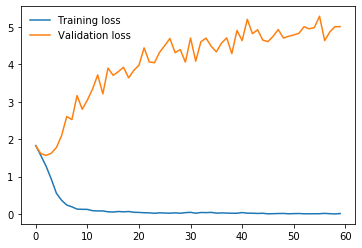

Train losses
[1.831349724591686, 1.558706975830388, 1.277043776652837, 0.9367438675788453, 0.5549673979846657, 0.3687606727335659, 0.24169233870612183, 0.1936054502609115, 0.1331482213652376, 0.12694483492428882, 0.12540412750946084, 0.090839820918698, 0.08386962236789278, 0.08457887063020376, 0.06083047132806729, 0.05475810431133067, 0.06898530232270962, 0.060374296142667684, 0.06899454561889475, 0.04831771325641477, 0.04448749609102452, 0.035703832160700395, 0.03273326790121001, 0.02106215267768366, 0.033281484344586505, 0.02809116853221419, 0.023489315157311823, 0.03372335017937694, 0.022386525828523685, 0.03868058671806064, 0.047027684785992965, 0.022563538348614263, 0.0422586931416831, 0.03919502442258264, 0.04567727836104214, 0.02560093166864463, 0.03102493762667409, 0.026283400766740597, 0.022852545537924405, 0.021925596870141586, 0.04072367040638996, 0.023833324537059376, 0.023625481968301203, 0.016999313522716462, 0.021930806187506254, 0.006554653953174649, 0.01035150288022714

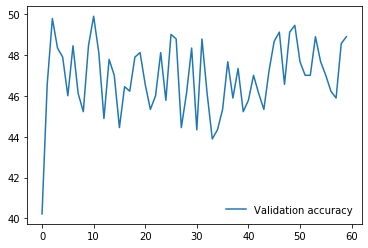

Validation accuracies
[40.22222222222222, 46.55555555555556, 49.77777777777778, 48.333333333333336, 47.888888888888886, 46.0, 48.44444444444444, 46.111111111111114, 45.22222222222222, 48.44444444444444, 49.888888888888886, 48.111111111111114, 44.888888888888886, 47.77777777777778, 47.0, 44.44444444444444, 46.44444444444444, 46.22222222222222, 47.888888888888886, 48.111111111111114, 46.55555555555556, 45.333333333333336, 46.0, 48.111111111111114, 45.77777777777778, 49.0, 48.77777777777778, 44.44444444444444, 46.111111111111114, 48.333333333333336, 44.333333333333336, 48.77777777777778, 46.111111111111114, 43.888888888888886, 44.333333333333336, 45.333333333333336, 47.666666666666664, 45.888888888888886, 47.333333333333336, 45.22222222222222, 45.77777777777778, 47.0, 46.111111111111114, 45.333333333333336, 47.22222222222222, 48.666666666666664, 49.111111111111114, 46.55555555555556, 49.111111111111114, 49.44444444444444, 47.666666666666664, 47.0, 47.0, 48.888888888888886, 47.666666666666

In [0]:
# Run
import timeit
gpu_train_time = timeit.timeit(
     "train_model_epochs(num_epochs)",
     setup="num_epochs=60",
     number=1,
     globals=globals(),
 )

labels, predicted, a, l = compute_validation_stats(test_loader)

print(a)
print(l)
print(gpu_train_time)

Confusion matrix, without normalization


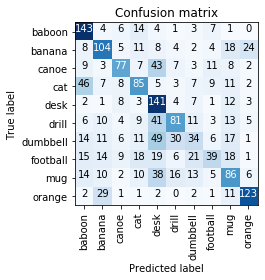

In [0]:
# Show confusion matrix
cm = confusion_matrix(labels, predicted)
plot_confusion_matrix(cm, class_names)

In [0]:
# Save model
path = f"/content/gdrive/My Drive/Escola/Master/Semester 2/Artificial Intelligence/Coursework 1/Models/model_2___{a:.1f}_{l:.3f}.py"
torch.save(model, F"{path}")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


#### Three layers

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()    #3x256x256
        self.conv1 = nn.Sequential(  
            nn.Conv2d(3, 16, 3),           #16x254x254    #parameters = 3 * (16 + 1(bias)) * 3^2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),   #16x127x127
            nn.Dropout(p = 0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 24, 4),           #24x124x124
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #24x62x62
            nn.Dropout(p = 0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(24, 32, 4),           #32x59x59
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #32x29x29=26912
            nn.Dropout(p = 0.3)
        )
        self.fc1 = nn.Linear(32*29*29, 512)       # #parameters = 26912 * (512 + 1 (bias))
        self.fc2 = nn.Linear(512, num_classes)
        #self.final = nn.Softmax(dim=1) # We shouldn't use this because CrossEntropyLoss is softmax, so we're already using it
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [0]:
# Initialize
torch.manual_seed(1)
model = ConvNet().to(device)

In [0]:
# Define the loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch / Batch [1 / 100]
Epoch / Batch [1 / 200]
Epoch / Batch [1 / 300]
Epoch / Batch [1 / 400]
Epoch / Batch [1 / 500]
Epoch / Batch [1 / 600]
Epoch / Batch [1 / 700]
-------------------------------- 
  Epoch 1/60 
  Train loss: 1.894 
  Validation loss: 1.848 
  Validation accuracy: 41.111% 
--------------------------------
Epoch / Batch [2 / 100]
Epoch / Batch [2 / 200]
Epoch / Batch [2 / 300]
Epoch / Batch [2 / 400]
Epoch / Batch [2 / 500]
Epoch / Batch [2 / 600]
Epoch / Batch [2 / 700]
-------------------------------- 
  Epoch 2/60 
  Train loss: 1.671 
  Validation loss: 1.752 
  Validation accuracy: 39.778% 
--------------------------------
Epoch / Batch [3 / 100]
Epoch / Batch [3 / 200]
Epoch / Batch [3 / 300]
Epoch / Batch [3 / 400]
Epoch / Batch [3 / 500]
Epoch / Batch [3 / 600]
Epoch / Batch [3 / 700]
-------------------------------- 
  Epoch 3/60 
  Train loss: 1.528 
  Validation loss: 1.577 
  Validation accuracy: 46.000% 
--------------------------------
Epoch / Batch [4

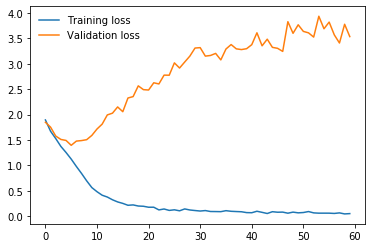

Train losses
[1.8937845516023297, 1.6714877998314532, 1.527921553795713, 1.373057649409408, 1.2538097695575148, 1.1243588618820695, 0.9795540893440924, 0.8423733566391286, 0.6963575185101649, 0.5641794100139045, 0.48319607175092405, 0.4141541472659801, 0.3784415476818375, 0.32447299429305315, 0.2822767154403447, 0.2533892705128883, 0.2164248183445277, 0.22355008382482577, 0.2017789080852482, 0.19689615505752225, 0.17789086037632174, 0.1782224246768782, 0.12536590185186586, 0.14338047802448273, 0.11557002618984523, 0.12734481972183673, 0.10773212247088476, 0.14445105664016025, 0.12383939391994839, 0.11307040182164478, 0.10306490925589794, 0.11239385941458233, 0.09402875997466484, 0.09276969598483313, 0.09085943852433093, 0.11011813130929385, 0.09816387881936156, 0.09316673141143043, 0.08899850791632222, 0.0722774762830456, 0.06989235801593906, 0.09896616210338428, 0.07745595794492567, 0.054854296526025394, 0.08989404773500365, 0.07991416101830864, 0.08195070532826602, 0.0607353974190460

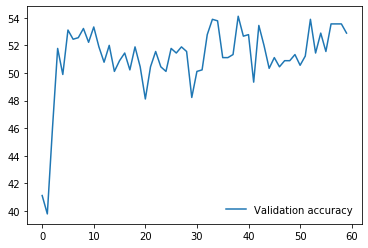

Validation accuracies
[41.111111111111114, 39.77777777777778, 46.0, 51.77777777777778, 49.888888888888886, 53.111111111111114, 52.44444444444444, 52.55555555555556, 53.22222222222222, 52.22222222222222, 53.333333333333336, 51.888888888888886, 50.77777777777778, 52.0, 50.111111111111114, 50.888888888888886, 51.44444444444444, 50.22222222222222, 51.888888888888886, 50.44444444444444, 48.111111111111114, 50.44444444444444, 51.55555555555556, 50.44444444444444, 50.111111111111114, 51.77777777777778, 51.44444444444444, 51.888888888888886, 51.55555555555556, 48.22222222222222, 50.111111111111114, 50.22222222222222, 52.77777777777778, 53.888888888888886, 53.77777777777778, 51.111111111111114, 51.111111111111114, 51.333333333333336, 54.111111111111114, 52.666666666666664, 52.77777777777778, 49.333333333333336, 53.44444444444444, 52.0, 50.333333333333336, 51.111111111111114, 50.44444444444444, 50.888888888888886, 50.888888888888886, 51.333333333333336, 50.55555555555556, 51.22222222222222, 53.8

In [0]:
# Run
import timeit
gpu_train_time = timeit.timeit(
     "train_model_epochs(num_epochs)",
     setup="num_epochs=60",
     number=1,
     globals=globals(),
 )
        
labels, predicted, a, l = compute_validation_stats(test_loader)

print(a)
print(l)
print(gpu_train_time)

Confusion matrix, without normalization


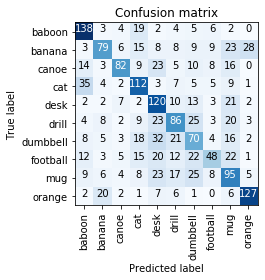

In [0]:
# Show confusion matrix
cm = confusion_matrix(labels, predicted)
plot_confusion_matrix(cm, class_names)

In [0]:
# Save model
path = f"/content/gdrive/My Drive/Escola/Master/Semester 2/Artificial Intelligence/Coursework 1/Models/model_3___{a:.1f}_{l:.3f}.py"
torch.save(model, F"{path}")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


#### Four layers

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()    #3x256x256
        self.conv1 = nn.Sequential(  
            nn.Conv2d(3, 16, 3),           #16x254x254
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),   #16x127x127
            nn.Dropout(p = 0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 24, 4),           #24x124x124
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #24x62x62
            nn.Dropout(p = 0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(24, 32, 4),           #32x59x59
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #32x29x29
            nn.Dropout(p = 0.3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 40, 4),           #40x26x26
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #40x13x13=6760
            nn.Dropout(p = 0.3)
        )
        self.fc1 = nn.Linear(40*13*13, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [0]:
# Initialize
torch.manual_seed(1)
model = ConvNet().to(device)

In [0]:
# Define the loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch / Batch [1 / 100]
Epoch / Batch [1 / 200]
Epoch / Batch [1 / 300]
Epoch / Batch [1 / 400]
Epoch / Batch [1 / 500]
Epoch / Batch [1 / 600]
Epoch / Batch [1 / 700]
-------------------------------- 
  Epoch 1/60 
  Train loss: 2.039 
  Validation loss: 1.910 
  Validation accuracy: 33.000% 
--------------------------------
Epoch / Batch [2 / 100]
Epoch / Batch [2 / 200]
Epoch / Batch [2 / 300]
Epoch / Batch [2 / 400]
Epoch / Batch [2 / 500]
Epoch / Batch [2 / 600]
Epoch / Batch [2 / 700]
-------------------------------- 
  Epoch 2/60 
  Train loss: 1.785 
  Validation loss: 1.859 
  Validation accuracy: 34.556% 
--------------------------------
Epoch / Batch [3 / 100]
Epoch / Batch [3 / 200]
Epoch / Batch [3 / 300]
Epoch / Batch [3 / 400]
Epoch / Batch [3 / 500]
Epoch / Batch [3 / 600]
Epoch / Batch [3 / 700]
-------------------------------- 
  Epoch 3/60 
  Train loss: 1.701 
  Validation loss: 1.773 
  Validation accuracy: 41.111% 
--------------------------------
Epoch / Batch [4

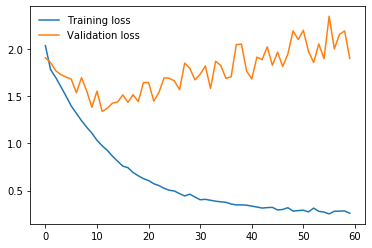

Train losses
[2.03872454468974, 1.7848586087602043, 1.7010881257087447, 1.6031291749952408, 1.503398066849878, 1.3990072003627188, 1.3210986555000852, 1.2423768798787582, 1.1733670298596324, 1.110178730625489, 1.0340020014587694, 0.9758752430529158, 0.9266767903859845, 0.8652196419685323, 0.811491028495549, 0.7598879993869568, 0.7426433202427656, 0.691483380187889, 0.6571066912812025, 0.6266891137332783, 0.6062364802709993, 0.572803723025443, 0.553000607541975, 0.5241824105419786, 0.5033650720104348, 0.49537887726792224, 0.4673017941906973, 0.4425669442200419, 0.46154600574734245, 0.4305695629286282, 0.4023513471149854, 0.4068481186168448, 0.39685633101590395, 0.3869936427640431, 0.38039340441904695, 0.37502429189945236, 0.35670926873832187, 0.3475099770815542, 0.3480443664764995, 0.34455319775769555, 0.3347223106639337, 0.3250501430238867, 0.31396797439319835, 0.31873361323841937, 0.32126580333800486, 0.29382977530662785, 0.29904134609372485, 0.31793091548275826, 0.2816458213601621, 0

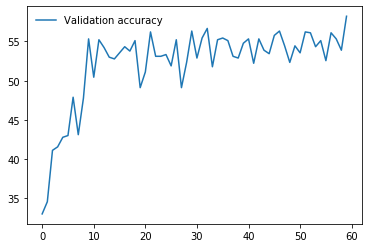

Validation accuracies
[33.0, 34.55555555555556, 41.111111111111114, 41.55555555555556, 42.77777777777778, 43.0, 47.888888888888886, 43.111111111111114, 47.77777777777778, 55.333333333333336, 50.44444444444444, 55.22222222222222, 54.22222222222222, 53.0, 52.77777777777778, 53.55555555555556, 54.333333333333336, 53.77777777777778, 55.111111111111114, 49.111111111111114, 51.111111111111114, 56.22222222222222, 53.111111111111114, 53.111111111111114, 53.333333333333336, 51.888888888888886, 55.22222222222222, 49.111111111111114, 52.333333333333336, 56.333333333333336, 52.888888888888886, 55.44444444444444, 56.666666666666664, 51.77777777777778, 55.22222222222222, 55.44444444444444, 55.111111111111114, 53.111111111111114, 52.888888888888886, 54.77777777777778, 55.333333333333336, 52.22222222222222, 55.333333333333336, 53.888888888888886, 53.44444444444444, 55.77777777777778, 56.333333333333336, 54.44444444444444, 52.333333333333336, 54.44444444444444, 53.55555555555556, 56.22222222222222, 56.

3294.824068455

In [0]:
# Run
import timeit
gpu_train_time = timeit.timeit(
     "train_model_epochs(num_epochs)",
     setup="num_epochs=60",
     number=1,
     globals=globals(),
 )
        
labels, predicted, a, l = compute_validation_stats(test_loader)

print(a)
print(l)
print(gpu_train_time)

Confusion matrix, without normalization


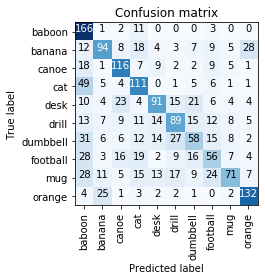

In [0]:
# Show confusion matrix
cm = confusion_matrix(labels, predicted)
plot_confusion_matrix(cm, class_names)

In [0]:
# Save model
path = f"/content/gdrive/My Drive/Escola/Master/Semester 2/Artificial Intelligence/Coursework 1/Models/model_4___{a:.1f}_{l:.3f}.py"
torch.save(model, F"{path}")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


#### Five layers

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()    #3x256x256
        self.conv1 = nn.Sequential(  
            nn.Conv2d(3, 16, 3),           #16x254x254
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),   #16x127x127
            nn.Dropout(p = 0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 24, 4),           #24x124x124
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #24x62x62
            nn.Dropout(p = 0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(24, 32, 4),           #32x59x59
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #32x29x29
            nn.Dropout(p = 0.3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 40, 4),           #40x26x26
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #40x13x13
            nn.Dropout(p = 0.3)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(40, 48, 4),           #48x10x10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #48x5x5=1200
            nn.Dropout(p = 0.3)
        )
        self.fc1 = nn.Linear(48*5*5, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [0]:
# Initialize
torch.manual_seed(1)
model = ConvNet().to(device)

In [0]:
# Define the loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch / Batch [1 / 100]
Epoch / Batch [1 / 200]
Epoch / Batch [1 / 300]
Epoch / Batch [1 / 400]
Epoch / Batch [1 / 500]
Epoch / Batch [1 / 600]
Epoch / Batch [1 / 700]
-------------------------------- 
  Epoch 1/100 
  Train loss: 2.173 
  Validation loss: 2.042 
  Validation accuracy: 24.222% 
--------------------------------
Epoch / Batch [2 / 100]
Epoch / Batch [2 / 200]
Epoch / Batch [2 / 300]
Epoch / Batch [2 / 400]
Epoch / Batch [2 / 500]
Epoch / Batch [2 / 600]
Epoch / Batch [2 / 700]
-------------------------------- 
  Epoch 2/100 
  Train loss: 1.904 
  Validation loss: 1.936 
  Validation accuracy: 31.000% 
--------------------------------
Epoch / Batch [3 / 100]
Epoch / Batch [3 / 200]
Epoch / Batch [3 / 300]
Epoch / Batch [3 / 400]
Epoch / Batch [3 / 500]
Epoch / Batch [3 / 600]
Epoch / Batch [3 / 700]
-------------------------------- 
  Epoch 3/100 
  Train loss: 1.815 
  Validation loss: 1.917 
  Validation accuracy: 30.111% 
--------------------------------
Epoch / Batch

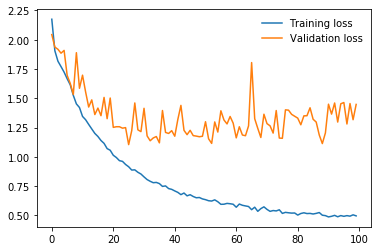

Train losses
[2.173312721821257, 1.9043035577547731, 1.8153410491907052, 1.7695039772442755, 1.722326331105329, 1.665841235878504, 1.614313315467786, 1.524100792135684, 1.4514721200475234, 1.4205135858906102, 1.3445843929415426, 1.3164999617764792, 1.2764273025662767, 1.237858364311269, 1.1997363840792385, 1.1736152448176127, 1.139200852531467, 1.1147223518130742, 1.0701642179587467, 1.056004664430461, 1.0133891526590748, 0.9941007053186446, 0.9673765143615946, 0.9611920243894994, 0.9348208628178853, 0.9153584133701276, 0.8872560267974883, 0.888979312543034, 0.8683142199885422, 0.8534089158558603, 0.8287493254667914, 0.8060506710848833, 0.7915078701479786, 0.7793692797044207, 0.7817433401564051, 0.7717800371462319, 0.7477084297289703, 0.7519273259275153, 0.7292205478031624, 0.7226132237480074, 0.7091433321158898, 0.6968632106891441, 0.677549766991193, 0.6912913825079269, 0.6673669378240097, 0.6769303420776038, 0.6617693861728997, 0.6508741078869945, 0.6531029107606956, 0.64106239455983

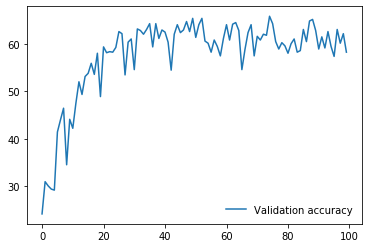

Validation accuracies
[24.22222222222222, 31.0, 30.11111111111111, 29.444444444444443, 29.22222222222222, 41.44444444444444, 44.0, 46.44444444444444, 34.55555555555556, 44.111111111111114, 42.22222222222222, 47.44444444444444, 52.0, 49.333333333333336, 53.111111111111114, 53.77777777777778, 55.888888888888886, 53.55555555555556, 58.0, 48.888888888888886, 59.333333333333336, 58.111111111111114, 58.333333333333336, 58.22222222222222, 59.22222222222222, 62.55555555555556, 62.111111111111114, 53.44444444444444, 60.333333333333336, 61.0, 54.55555555555556, 63.111111111111114, 62.77777777777778, 62.0, 63.0, 64.22222222222223, 59.333333333333336, 64.22222222222223, 61.111111111111114, 62.888888888888886, 62.44444444444444, 60.333333333333336, 54.44444444444444, 62.0, 64.0, 62.333333333333336, 62.888888888888886, 64.66666666666667, 62.55555555555556, 65.33333333333333, 61.333333333333336, 64.0, 65.33333333333333, 60.55555555555556, 60.111111111111114, 58.22222222222222, 60.77777777777778, 59.4

In [0]:
# Run
import timeit
gpu_train_time = timeit.timeit(
     "train_model_epochs(num_epochs)",
     setup="num_epochs=100",
     number=1,
     globals=globals(),
 )

labels, predicted, a, l = compute_validation_stats(test_loader)

print(a)
print(l)
print(gpu_train_time)

Confusion matrix, without normalization


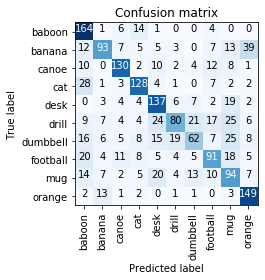

In [0]:
# Show confusion matrix
cm = confusion_matrix(labels, predicted)
plot_confusion_matrix(cm, class_names)

In [0]:
# Save model
path = f"/content/gdrive/My Drive/Escola/Master/Semester 2/Artificial Intelligence/Coursework 1/Models/model_5___{a:.1f}_{l:.3f}.py"
torch.save(model, F"{path}")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Choose one more architectural element to test (filter size, max-pool kernel size, number/dimensions of fully-connected layers, etc.).

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()    #3x256x256
        self.conv1 = nn.Sequential(  
            nn.Conv2d(3, 16, 4),           #16x253x253
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),   #16x126x126
            nn.Dropout(p = 0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 24, 5),           #24x122x122
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #24x61x61
            nn.Dropout(p = 0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(24, 32, 5),           #32x57x57
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #32x28x28=25088
            nn.Dropout(p = 0.3)
        )
        self.fc1 = nn.Linear(32*28*28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [0]:
# Initialize
torch.manual_seed(1)
model = ConvNet().to(device)

In [0]:
# Define the loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch / Batch [1 / 100]
Epoch / Batch [1 / 200]
Epoch / Batch [1 / 300]
Epoch / Batch [1 / 400]
Epoch / Batch [1 / 500]
Epoch / Batch [1 / 600]
Epoch / Batch [1 / 700]
-------------------------------- 
  Epoch 1/60 
  Train loss: 1.917 
  Validation loss: 2.028 
  Validation accuracy: 28.000% 
--------------------------------
Epoch / Batch [2 / 100]
Epoch / Batch [2 / 200]
Epoch / Batch [2 / 300]
Epoch / Batch [2 / 400]
Epoch / Batch [2 / 500]
Epoch / Batch [2 / 600]
Epoch / Batch [2 / 700]
-------------------------------- 
  Epoch 2/60 
  Train loss: 1.670 
  Validation loss: 1.833 
  Validation accuracy: 33.778% 
--------------------------------
Epoch / Batch [3 / 100]
Epoch / Batch [3 / 200]
Epoch / Batch [3 / 300]
Epoch / Batch [3 / 400]
Epoch / Batch [3 / 500]
Epoch / Batch [3 / 600]
Epoch / Batch [3 / 700]
-------------------------------- 
  Epoch 3/60 
  Train loss: 1.486 
  Validation loss: 1.645 
  Validation accuracy: 44.111% 
--------------------------------
Epoch / Batch [4

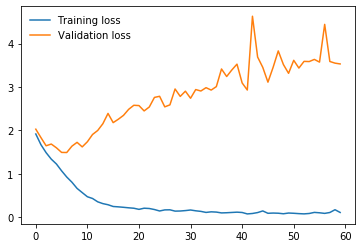

Train losses
[1.9167712994940995, 1.6696735500986806, 1.4862227082101223, 1.3371671114097996, 1.22488355326471, 1.0679455374930111, 0.9248464426337765, 0.8059081222086691, 0.6626498343678295, 0.5658984940858359, 0.4704593331718505, 0.4301292423518176, 0.35348467315135873, 0.311919952577292, 0.2861337785226137, 0.2457257894241265, 0.23734383591389294, 0.2270562284564609, 0.21527785552561585, 0.20562525146503738, 0.17956480003779915, 0.20607448495962294, 0.19948670634914775, 0.1755005891817778, 0.1422111415469707, 0.16713892201406097, 0.1692341271844612, 0.13891623573859935, 0.14149545460258645, 0.15129431068594687, 0.16481758544438987, 0.146274592595052, 0.13302451549901576, 0.10901434753600717, 0.12258774117769929, 0.11661247988491494, 0.09763234146506654, 0.10170649228437903, 0.10818684278859705, 0.11479000618615126, 0.10749073912800872, 0.07451219981545724, 0.08455488233245569, 0.10542495567635231, 0.14320948538441344, 0.08894665906120677, 0.09419917924149993, 0.09066312688256278, 0.

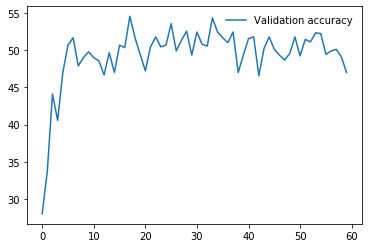

Validation accuracies
[28.0, 33.77777777777778, 44.111111111111114, 40.55555555555556, 47.0, 50.666666666666664, 51.666666666666664, 47.888888888888886, 49.0, 49.77777777777778, 49.0, 48.55555555555556, 46.666666666666664, 49.666666666666664, 47.0, 50.666666666666664, 50.333333333333336, 54.55555555555556, 51.666666666666664, 49.44444444444444, 47.22222222222222, 50.44444444444444, 51.77777777777778, 50.44444444444444, 50.666666666666664, 53.55555555555556, 49.888888888888886, 51.333333333333336, 52.55555555555556, 49.333333333333336, 52.44444444444444, 50.77777777777778, 50.55555555555556, 54.333333333333336, 52.44444444444444, 51.666666666666664, 51.0, 52.44444444444444, 47.0, 49.333333333333336, 51.55555555555556, 51.77777777777778, 46.55555555555556, 50.22222222222222, 51.77777777777778, 50.111111111111114, 49.333333333333336, 48.666666666666664, 49.55555555555556, 51.77777777777778, 49.22222222222222, 51.44444444444444, 51.111111111111114, 52.333333333333336, 52.22222222222222, 49

3285.6940101880027

In [0]:
# Run
import timeit
gpu_train_time = timeit.timeit(
     "train_model_epochs(num_epochs)",
     setup="num_epochs=60",
     number=1,
     globals=globals(),
 )

labels, predicted, a, l = compute_validation_stats(test_loader)

print(a)
print(l)
print(gpu_train_time)

Confusion matrix, without normalization


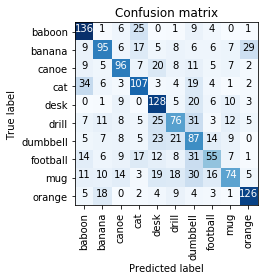

In [0]:
# Show confusion matrix
cm = confusion_matrix(labels, predicted)
plot_confusion_matrix(cm, class_names)

In [0]:
# Save model
path = f"/content/gdrive/My Drive/Escola/Master/Semester 2/Artificial Intelligence/Coursework 1/Models/model_3_mod___{a:.1f}_{l:.3f}.py"
torch.save(model, F"{path}")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# **2. Filter visualisation**

The best model is the one with 5 layers at epoch 26

In [0]:
import matplotlib.pyplot as plt

def normalize (layer):
  f_min, f_max = layer.min(), layer.max()
  return (layer - f_min) / (f_max - f_min)

def getFilters (model):
  filters = []
  for idx, x in enumerate(model.modules()):
    if '.conv.' in str(type(x)):
      filters.append(normalize(x.weight.data))
  return filters

def showFilters (filter):
  fig = plt.figure()
  plt.figure(figsize=(22,6))
  size = filter.size() # Out (filters) - In - 4x4
  for idx, filt  in enumerate(filter):
    for layer in range(size[1]):
      plt.subplot(size[1],size[0], idx + 1 + size[0]*layer)
      plt.imshow(filt[layer, :, :], cmap="gray")
      plt.axis('off')
  fig.show()

Show filters before training

<Figure size 432x288 with 0 Axes>

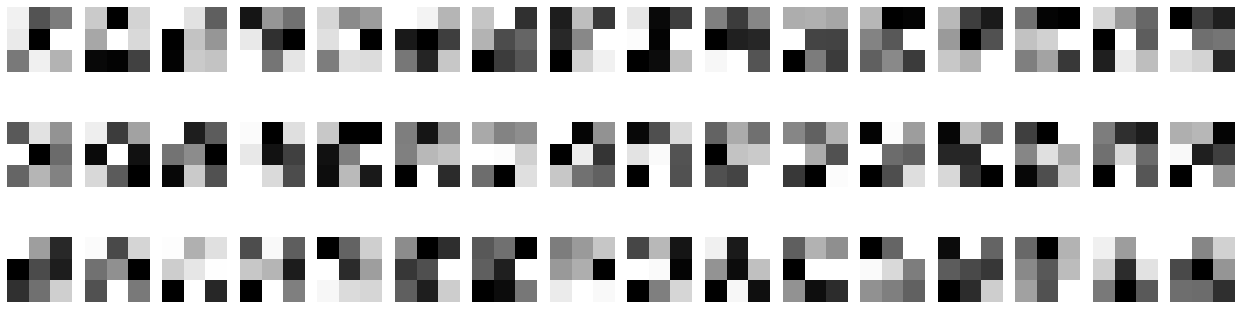

In [0]:
filters = getFilters(model.cpu())
showFilters(filters[0])

Show filters at halfway during training (after epoch 13)

Epoch / Batch [1 / 100]
Epoch / Batch [1 / 200]
Epoch / Batch [1 / 300]
Epoch / Batch [1 / 400]
Epoch / Batch [1 / 500]
Epoch / Batch [1 / 600]
Epoch / Batch [1 / 700]
-------------------------------- 
  Epoch 1/13 
  Train loss: 2.175 
  Validation loss: 2.032 
  Validation accuracy: 26.667% 
--------------------------------
Epoch / Batch [2 / 100]
Epoch / Batch [2 / 200]
Epoch / Batch [2 / 300]
Epoch / Batch [2 / 400]
Epoch / Batch [2 / 500]
Epoch / Batch [2 / 600]
Epoch / Batch [2 / 700]
-------------------------------- 
  Epoch 2/13 
  Train loss: 1.902 
  Validation loss: 1.894 
  Validation accuracy: 35.444% 
--------------------------------
Epoch / Batch [3 / 100]
Epoch / Batch [3 / 200]
Epoch / Batch [3 / 300]
Epoch / Batch [3 / 400]
Epoch / Batch [3 / 500]
Epoch / Batch [3 / 600]
Epoch / Batch [3 / 700]
-------------------------------- 
  Epoch 3/13 
  Train loss: 1.815 
  Validation loss: 1.943 
  Validation accuracy: 27.889% 
--------------------------------
Epoch / Batch [4

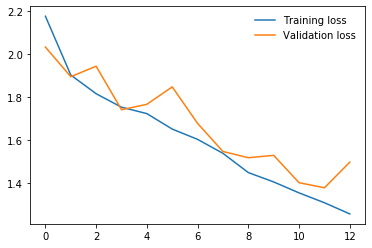

Train losses
[2.175071586812208, 1.9019684278722948, 1.8150256380514445, 1.752534240559878, 1.722611354465412, 1.650789858650435, 1.6029824449628742, 1.5380487608425508, 1.4486323875672926, 1.4051247970933842, 1.3543280864200615, 1.308555395696974, 1.256583021225663]
Validation losses
[2.0317916500884876, 1.8942742685301115, 1.9428131854639643, 1.7406753649753808, 1.7659555900413377, 1.8467900172799034, 1.677185718992115, 1.5465770558973329, 1.5177133104442495, 1.5286928135736855, 1.4016306627113206, 1.377923384704421, 1.4970647043886438]


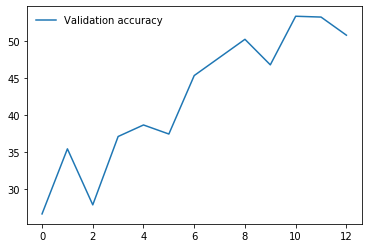

Validation accuracies
[26.666666666666668, 35.44444444444444, 27.88888888888889, 37.111111111111114, 38.666666666666664, 37.44444444444444, 45.333333333333336, 47.77777777777778, 50.22222222222222, 46.77777777777778, 53.333333333333336, 53.22222222222222, 50.77777777777778]


<Figure size 432x288 with 0 Axes>

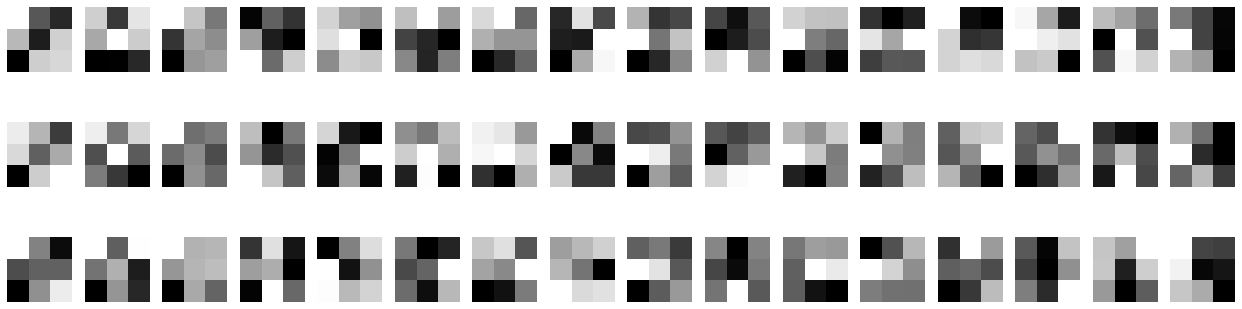

In [0]:
import timeit
torch.manual_seed(1)
model = model.to(device)

gpu_train_time = timeit.timeit(
     "train_model_epochs(num_epochs)",
     setup="num_epochs=26//2",
     number=1,
     globals=globals(),
 )

filters = getFilters(model.cpu())
showFilters(filters[0])

Show filters after training (after epoch 26)

Epoch / Batch [1 / 100]
Epoch / Batch [1 / 200]
Epoch / Batch [1 / 300]
Epoch / Batch [1 / 400]
Epoch / Batch [1 / 500]
Epoch / Batch [1 / 600]
Epoch / Batch [1 / 700]
-------------------------------- 
  Epoch 1/13 
  Train loss: 1.261 
  Validation loss: 1.461 
  Validation accuracy: 51.111% 
--------------------------------
Epoch / Batch [2 / 100]
Epoch / Batch [2 / 200]
Epoch / Batch [2 / 300]
Epoch / Batch [2 / 400]
Epoch / Batch [2 / 500]
Epoch / Batch [2 / 600]
Epoch / Batch [2 / 700]
-------------------------------- 
  Epoch 2/13 
  Train loss: 1.213 
  Validation loss: 1.332 
  Validation accuracy: 55.111% 
--------------------------------
Epoch / Batch [3 / 100]
Epoch / Batch [3 / 200]
Epoch / Batch [3 / 300]
Epoch / Batch [3 / 400]
Epoch / Batch [3 / 500]
Epoch / Batch [3 / 600]
Epoch / Batch [3 / 700]
-------------------------------- 
  Epoch 3/13 
  Train loss: 1.190 
  Validation loss: 1.482 
  Validation accuracy: 51.889% 
--------------------------------
Epoch / Batch [4

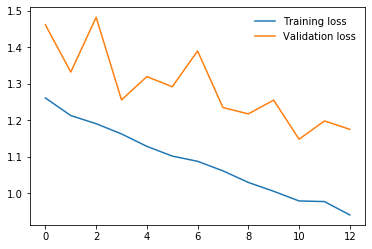

Train losses
[1.260678661315877, 1.2125593190492712, 1.1903907911199603, 1.1624218546194474, 1.1283460827118854, 1.1018199787905374, 1.0874948841212364, 1.061373273241641, 1.0297396763554079, 1.005465175861937, 0.9790619333761598, 0.9773713507628078, 0.9408617620616395]
Validation losses
[1.4605971036759098, 1.3316368291863299, 1.481564529174197, 1.2554242624118266, 1.3191969041275766, 1.2914744903028539, 1.389193890369044, 1.234566529767703, 1.2172091252508417, 1.2548213801552763, 1.147897574753888, 1.1979376953260032, 1.17498172859175]


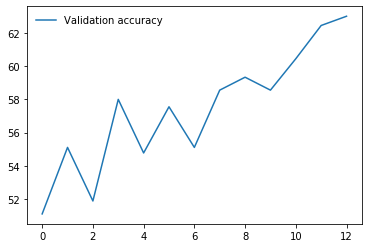

Validation accuracies
[51.111111111111114, 55.111111111111114, 51.888888888888886, 58.0, 54.77777777777778, 57.55555555555556, 55.111111111111114, 58.55555555555556, 59.333333333333336, 58.55555555555556, 60.44444444444444, 62.44444444444444, 63.0]


<Figure size 432x288 with 0 Axes>

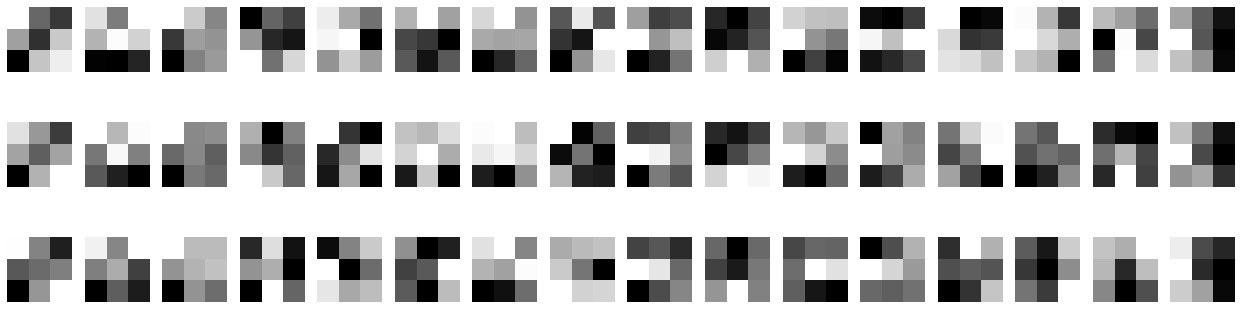

In [0]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

gpu_train_time = timeit.timeit(
     "train_model_epochs(num_epochs)",
     setup="num_epochs=26//2",
     number=1,
     globals=globals(),
 )

filters = getFilters(model.cpu())
showFilters(filters[0])

# **3. Feature map visualisation**

Load best model

In [0]:
model = torch.load(F"/content/gdrive/My Drive/Escola/Master/Semester 2/Artificial Intelligence/Coursework 1/Models/model_5___62.7_1.097.py")
model = model.to(device)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Select 'num' random images but from different class, it does not check 'num'
def getDifferenClassesImages(num):
  dataloader_iterator = iter(test_loader)
  images = torch.tensor([], dtype=torch.float)
  labels = []
  for i in range(num):
    tmp1, tmp2 = next(dataloader_iterator)
    tmp3 = random.randint(0, len(tmp1) - 1)
    while tmp3 in labels:
      tmp3 = random.randint(0, len(tmp1) - 1)
    images = torch.cat((images, tmp1[tmp3:(tmp3+1),:,:,:].detach()))
    labels = np.append(labels, tmp2[tmp3].detach().numpy())
  return images, labels

# Show 'fm_number' Feature Map for input
def showFeatureMaps (input, fm_number):
  fig = plt.figure()
  plt.figure(figsize=(max(round(input.size()[1]/14), 9),6))
  
  for i  in range(fm_number):
    plt.subplot(1,fm_number, i + 1)
    plt.imshow(input[i, :, :], cmap="gray")

  fig.tight_layout()  
  fig.show()

# Special function for hook
def Get_Features_and_Show(self, input, output):
   showFeatureMaps(output.data[0].detach().cpu(), 4)
   showFeatureMaps(output.data[1].detach().cpu(), 4)
   return None

In [0]:
# Set to show feature maps after each convolution
for idx, x in enumerate(model.modules()):
  if '.conv.' in str(type(x)):
    x.register_forward_hook(Get_Features_and_Show)

[7. 1.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[ -2.3221,  -2.4222,   4.2025,  -2.6096,  -4.0095,   2.0820,  -4.2753,
           9.8994,   1.3698,  -2.9758],
        [-12.3089,   4.5467,   1.7978,  -7.9073,  -0.8580,   1.0420,  -3.6516,
           6.5869,   7.2724,   0.3853]], device='cuda:0',
       grad_fn=<AddmmBackward>)

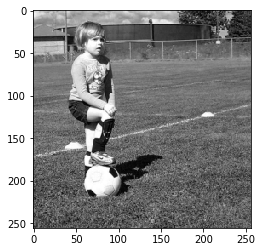

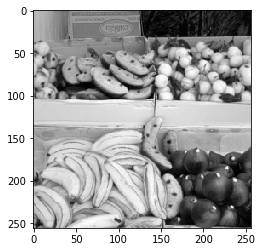

<Figure size 432x288 with 0 Axes>

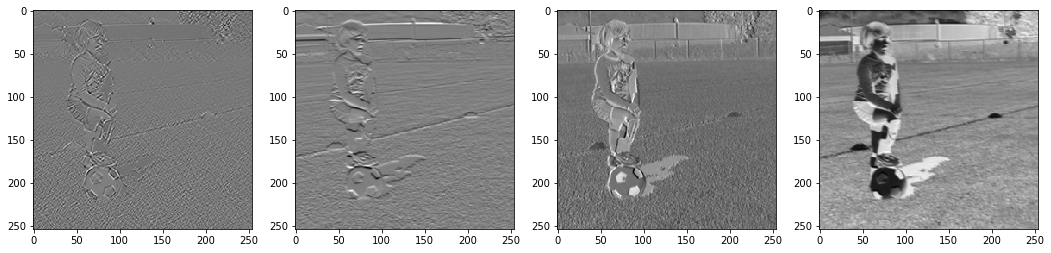

<Figure size 432x288 with 0 Axes>

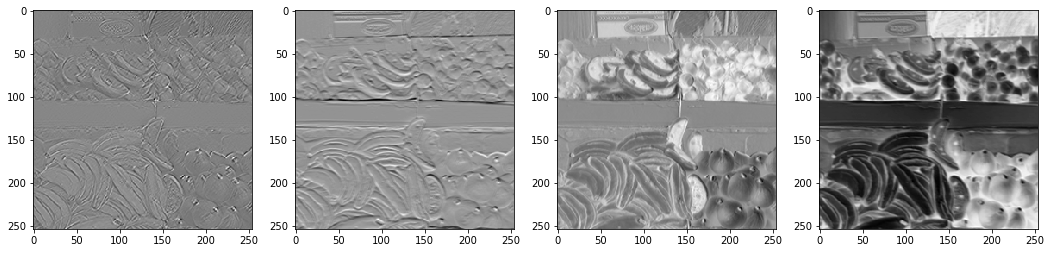

<Figure size 432x288 with 0 Axes>

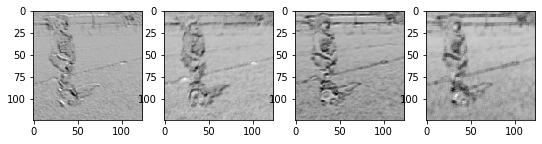

<Figure size 432x288 with 0 Axes>

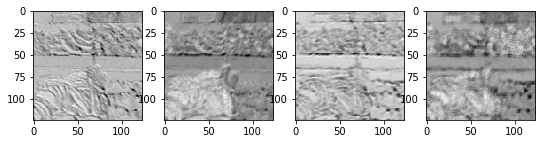

<Figure size 432x288 with 0 Axes>

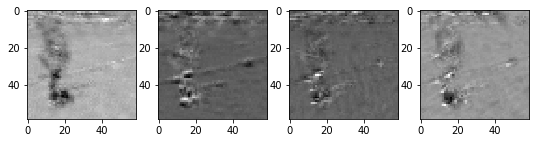

<Figure size 432x288 with 0 Axes>

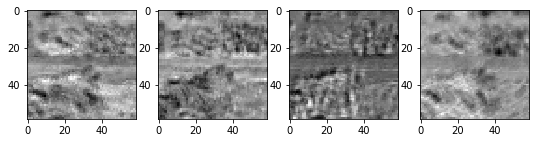

<Figure size 432x288 with 0 Axes>

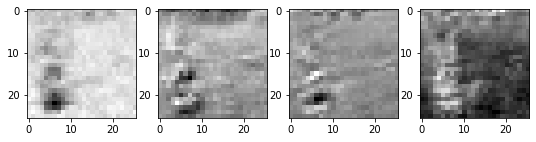

<Figure size 432x288 with 0 Axes>

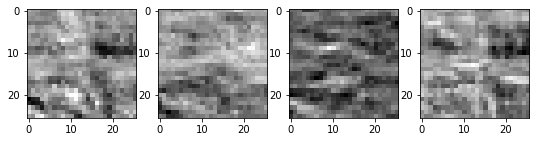

<Figure size 432x288 with 0 Axes>

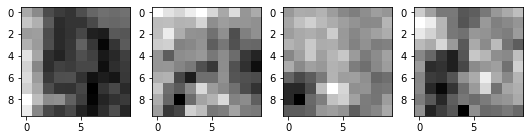

<Figure size 432x288 with 0 Axes>

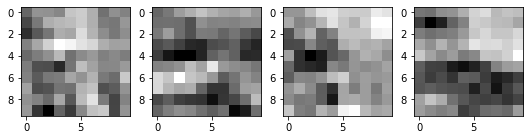

In [0]:
# Run
#images, labels = getDifferenClassesImages(2)
print(labels)
images = images.cpu()
for im in images:
  plt.figure()
  plt.imshow(im[0, :, :], cmap="gray")

images = images.to(device)
model(images)

# **4. Improving network performance**

In [0]:
data_transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
        transforms.RandomErasing(),
    ])

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform_train,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)

train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

valid_loader = torch.utils.data.DataLoader(
    ins_dataset_valid,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()    #3x256x256
        
        # 1st NET
        self.conv1_1 = nn.Sequential(  
            nn.Conv2d(3, 16, 3),           #16x254x254
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),   #16x127x127
            nn.Dropout(p = 0.3)
        )
        self.conv1_2 = nn.Sequential(
            nn.Conv2d(16, 24, 3),           #24x125x125
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #24x62x62
            nn.Dropout(p = 0.3)
        )
        self.conv1_3 = nn.Sequential(
            nn.Conv2d(24, 32, 3),           #32x60x60
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #32x30x30
            nn.Dropout(p = 0.3)
        )
        self.conv1_4 = nn.Sequential(
            nn.Conv2d(32, 40, 3),           #40x28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #40x14x14
            nn.Dropout(p = 0.3)
        )
        self.conv1_5 = nn.Sequential(
            nn.Conv2d(40, 48, 3),           #48x12x12
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #48x6x6=1728
            nn.Dropout(p = 0.3)
        )
        self.fc1_1 = nn.Linear(48*6*6, 512)
        self.fc1_2 = nn.Linear(512, num_classes)

        # 2nd NET
        self.conv2_1 = nn.Sequential(  
            nn.Conv2d(3, 16, 5),           #16x252x252
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),   #16x126x126
            nn.Dropout(p = 0.3)
        )
        self.conv2_2 = nn.Sequential(
            nn.Conv2d(16, 24, 5),           #24x122x122
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #24x61x61
            nn.Dropout(p = 0.3)
        )
        self.conv2_3 = nn.Sequential(
            nn.Conv2d(24, 32, 5),           #32x57x57
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #32x28x28
            nn.Dropout(p = 0.3)
        )
        self.conv2_4 = nn.Sequential(
            nn.Conv2d(32, 40, 5),           #40x24x24
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #40x12x12
            nn.Dropout(p = 0.3)
        )
        self.conv2_5 = nn.Sequential(
            nn.Conv2d(40, 48, 5),           #48x8x8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),    #48x4x4=768
            nn.Dropout(p = 0.3)
        )
        self.fc2_1 = nn.Linear(48*4*4, 512)
        self.fc2_2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        y = x

        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.conv1_3(x)
        x = self.conv1_4(x)
        x = self.conv1_5(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1_1(x)
        x = self.fc1_2(x)

        y = self.conv2_1(y)
        y = self.conv2_2(y)
        y = self.conv2_3(y)
        y = self.conv2_4(y)
        y = self.conv2_5(y)
        y = y.reshape(y.size(0), -1)
        y = self.fc2_1(y)
        y = self.fc2_2(y)

        return (x + y) / 2

In [0]:
# Initialize
torch.manual_seed(1)
model = ConvNet().to(device)

In [0]:
# Define the loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch / Batch [1 / 100]
Epoch / Batch [1 / 200]
Epoch / Batch [1 / 300]
Epoch / Batch [1 / 400]
Epoch / Batch [1 / 500]
Epoch / Batch [1 / 600]
Epoch / Batch [1 / 700]
-------------------------------- 
  Epoch 1/100 
  Train loss: 2.188 
  Validation loss: 2.023 
  Validation accuracy: 24.111% 
--------------------------------
Epoch / Batch [2 / 100]
Epoch / Batch [2 / 200]
Epoch / Batch [2 / 300]
Epoch / Batch [2 / 400]
Epoch / Batch [2 / 500]
Epoch / Batch [2 / 600]
Epoch / Batch [2 / 700]
-------------------------------- 
  Epoch 2/100 
  Train loss: 1.995 
  Validation loss: 1.973 
  Validation accuracy: 29.667% 
--------------------------------
Epoch / Batch [3 / 100]
Epoch / Batch [3 / 200]
Epoch / Batch [3 / 300]
Epoch / Batch [3 / 400]
Epoch / Batch [3 / 500]
Epoch / Batch [3 / 600]
Epoch / Batch [3 / 700]
-------------------------------- 
  Epoch 3/100 
  Train loss: 1.889 
  Validation loss: 1.803 
  Validation accuracy: 37.556% 
--------------------------------
Epoch / Batch

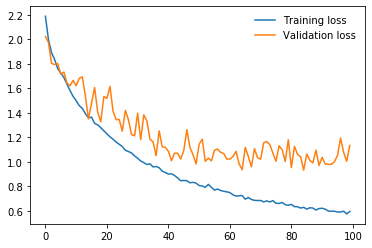

Train losses
[2.1879504230724374, 1.995333055100465, 1.8894880988119822, 1.8346483308046602, 1.7599328078594305, 1.7251473020781116, 1.6873971344855836, 1.634845545903075, 1.5811388466110083, 1.5339469772758823, 1.498379827755962, 1.4584908241094066, 1.435563163103791, 1.3922507426687303, 1.359541726899026, 1.364163124962204, 1.3133905482322432, 1.3014551206364244, 1.2782090377762232, 1.2527304568947268, 1.2278533641835154, 1.20349974854646, 1.1840197305161941, 1.1606773139559072, 1.142356646318121, 1.1240240373284685, 1.093757053430613, 1.083196061289855, 1.07183280708221, 1.048017861576855, 1.0275864904264205, 1.0061230102393228, 0.9926872606280491, 0.9773987704878531, 0.983106511347185, 0.9578641736265366, 0.9611499729722285, 0.9508032865330652, 0.9231234971188047, 0.9119278579042648, 0.8993279040994377, 0.9012811033026821, 0.8876689720501755, 0.8679100962989221, 0.8450418261026368, 0.8471070476594915, 0.845227748363605, 0.8282907628808832, 0.8317609981156243, 0.825661421465087, 0.8

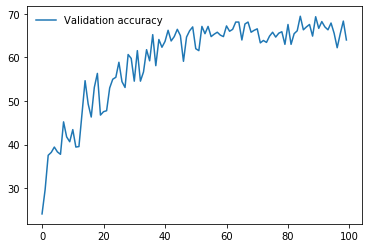

Validation accuracies
[24.11111111111111, 29.666666666666668, 37.55555555555556, 38.22222222222222, 39.44444444444444, 38.333333333333336, 37.77777777777778, 45.22222222222222, 41.77777777777778, 40.666666666666664, 43.44444444444444, 39.44444444444444, 39.55555555555556, 47.111111111111114, 54.666666666666664, 49.333333333333336, 46.333333333333336, 53.111111111111114, 56.333333333333336, 46.77777777777778, 47.55555555555556, 47.77777777777778, 53.0, 55.0, 55.44444444444444, 58.888888888888886, 54.44444444444444, 53.111111111111114, 60.666666666666664, 59.77777777777778, 54.55555555555556, 61.55555555555556, 54.55555555555556, 56.666666666666664, 61.77777777777778, 59.22222222222222, 65.22222222222223, 58.111111111111114, 64.11111111111111, 62.333333333333336, 63.666666666666664, 66.22222222222223, 63.77777777777778, 64.77777777777777, 66.44444444444444, 65.0, 59.111111111111114, 64.66666666666667, 66.11111111111111, 67.0, 62.0, 61.55555555555556, 67.11111111111111, 65.44444444444444,

In [0]:
# Run
import timeit
gpu_train_time = timeit.timeit(
     "train_model_epochs(num_epochs)",
     setup="num_epochs=100",
     number=1,
     globals=globals(),
 )

labels, predicted, a, l = compute_validation_stats(test_loader)

print(a)
print(l)
print(gpu_train_time)

Confusion matrix, without normalization


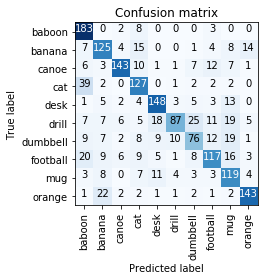

In [0]:
# Show confusion matrix
cm = confusion_matrix(labels, predicted)
plot_confusion_matrix(cm, class_names)

In [0]:
# Save model
path = f"/content/gdrive/My Drive/Escola/Master/Semester 2/Artificial Intelligence/Coursework 1/Models/model_Improvement___{a:.1f}_{l:.3f}.py"
torch.save(model, F"{path}")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
